# Simple flow model of the housing pipeline

Similar to the worked pandemic example in the other file, we want to simulate the following flow of homes through stages:

$$ P \rightarrow A \rightarrow S \rightarrow C $$

That is, moving from Planning ($P$) to Approved ($A$) to Starts ($S$), to Completions ($C$).

First we will design the model to run forwards (given x number of homes in each stage at the start and some rate of homes flowing into the planning stage, what is the number of completions by the end?) But then we should be able to run it backwards (start with desired completions and go back).

## The model

First, homes are **in planning**. There is some scalar number of applications that can be processed by the planning system in a year, and there is some number of applications that enter it. Let's call them $c$ for Planning System Capacity and $p$ for Planning Applications. Instead of a differential equation we can just use quarterly steps.

$$ P_t = P_{t-1} - c + p $$

**Approved homes** simply grow by the start_to_finish system capacity minus some amount that will never get built and exit the system. The rate of buildout is given by some constant $b$. They leave by some rate defined by average time spent between approval and starts (lower case $a$)

$$ A_t = A_{t-1} + c * b - A_{t-1}\frac{1}{a} $$

**Starts** basically tracks the number of homes under construction. The flow in will be equal to the flow out from A. The flow out will be defined by some rate of average project time ($s$ for avg time spent in starts, in quarters).

$$ S_t = S_{t-1} + A_{t-1}\frac{1}{a} - S_{t-1}\frac{1}{s} $$

**Completions** will be the flow out from Starts. We will keep track of total completions.

$$ C_t = C_{t-1} + S_{t-1}\frac{1}{s} $$

But we're of course also curious about the _rate_ of completions, so we will keep track of the flow into C, $C_{flow} = S_{t-1}\frac{1}{s}$ and of flows into starts $S_{flow} = A_{t-1}\frac{1}{a}$.

At any given time the system can be described as a vector:

$$ x = (P, A, S, C) $$

And the function we're looking for is:

$$ x_t = F(x_{t-1})

## Implementation

In [2]:
import pandas as pd

In [3]:
# For now, set constant values for applications, capacity, time...

applications = 20000
planning_capacity = 15000
buildout_rate = .9
approval_to_start_time = 4 # 1 year
start_to_finish_time = 8 # 2 years

simulation_length = 20 # simulation length in quarters, 5 years (this parliament)

# Initialise some values

planning_0 = 10500
approved_0 = 10500
started_0 = 34143
completed_0 = 0

start_state = planning_0, approved_0, started_0, completed_0

In [4]:
# Describe the function that calculates the next time step

def calculate_next_state(previous_state,
                         applications,
                         planning_capacity,
                         buildout_rate,
                         approval_to_start_time,
                         start_to_finish_time):
    """
    We take in the vector of the previous state.

    We calculate the next state.
    """

    # Initial values
    planning_0, approved_0, started_0, completed_0 = previous_state

    # Calculate new values
    planning = planning_0 - planning_capacity + applications
    starts = approved_0 * (1/approval_to_start_time)
    approved = approved_0 + planning_capacity * buildout_rate - starts
    completions = started_0 * (1/start_to_finish_time)
    started = started_0 + starts - completions
    completed = completed_0 + completions

    next_state = planning, approved, started, completed

    return next_state, planning_capacity, starts, completions

In [5]:
# Alternate function where planning takes time as well rather than being a fixed capactity.

def calculate_next_state(previous_state,
                         applications,
                         planning_time,
                         buildout_rate,
                         approval_to_start_time,
                         start_to_finish_time):
    """
    We take in the vector of the previous state.

    We calculate the next state.
    """

    # Initial values
    planning_0, approved_0, started_0, completed_0 = previous_state

    # Calculate new values
    approvals = planning_0 * (1/planning_time)
    planning = planning_0 - approvals + applications
    
    starts = approved_0 * (1/approval_to_start_time)
    approved = approved_0 + approvals * buildout_rate - starts
    
    completions = started_0 * (1/start_to_finish_time)
    started = started_0 + starts - completions
    completed = completed_0 + completions

    next_state = planning, approved, started, completed

    return next_state, approvals, starts, completions

In [6]:
# Calcualte quarter label based on time period.

def quarter_label_from_period(period, start_year=2024, start_quarter=2):
    
    total_quarters = start_quarter - 1 + period

    year = start_year + total_quarters//4
    quarter = total_quarters % 4 + 1
    return f"Q{quarter} {year}"

# Test
print(quarter_label_from_period(0)) 

Q2 2024


In [22]:
# Wrapper function for running the entire simulation.

import pandas as pd


def run_simulation(simulation_length, 
                   start_state,
                   start_approved_flow,
                   start_starts_flow,
                   start_completions_flow, 
                   applications, 
                   planning_time, 
                   buildout_rate, 
                   approval_to_start_time, 
                   start_to_finish_time):
    
    # Initialise lists to store values

    quarter, application_flow, planning_volume, approved_flow, approved_volume, starts_flow, started_volume, completions_flow, completed_volume = [], [], [], [], [], [], [], [], []
    
    t = 0
    quarter.append(quarter_label_from_period(t))
    application_flow.append(applications[t] if type(applications) is list else applications)
    planning_volume.append(start_state[0])
    approved_flow.append(start_approved_flow)
    approved_volume.append(start_state[1])
    starts_flow.append(start_starts_flow)
    started_volume.append(start_state[2])
    completions_flow.append(start_completions_flow)
    completed_volume.append(start_state[3])

    t += 1

    # planning, approved, starts, completions
    current_state = start_state[0] + application_flow[0], *start_state[1:]

    for period in range(t,simulation_length):

        applications_period = applications[t] if type(applications) is list else applications
        
        # Allowing for listlike values for other flow control variables.
        planning_time_period = planning_time[t] if type(planning_time) is list else planning_time
        start_to_finish_time_period = start_to_finish_time[t] if type(start_to_finish_time) is list else start_to_finish_time
        approval_to_start_time_period = approval_to_start_time[t] if type(approval_to_start_time) is list else approval_to_start_time



        results = calculate_next_state(current_state, applications_period, planning_time_period, buildout_rate, approval_to_start_time_period, start_to_finish_time_period)
        current_state = results[0]
        
        # Append values to lists

        quarter.append(quarter_label_from_period(t))
        
        application_flow.append(applications_period)
        planning_volume.append(results[0][0])
        
        approved_flow.append(results[1])
        approved_volume.append(results[0][1])
        
        starts_flow.append(results[2])
        started_volume.append(results[0][2])
        
        completions_flow.append(results[3])
        completed_volume.append(results[0][3])

        t += 1

    results_df = pd.DataFrame({
        'quarter' : quarter,
        'applications' : application_flow,
        'in planning' : planning_volume,
        'approvals' : approved_flow,
        'approved not yet started' : approved_volume,
        'starts' : starts_flow,
        'in construction' : started_volume,
        'completions' : completions_flow,
        'total completed' : completed_volume
    })

    return results_df
 

In [8]:
import matplotlib.pyplot as plt

def plot_pipeline_flow(results_df):
    """
    Plots a line chart for 'approvals', 'starts', and 'completions' from the given DataFrame.
    
    :param results_df: DataFrame containing the pipeline data.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot the data
    plt.plot(results_df['quarter'], results_df['approvals'], label='Approvals', marker='o')
    plt.plot(results_df['quarter'], results_df['applications'], label='Applications', marker='o')
    plt.plot(results_df['quarter'], results_df['starts'], label='Starts', marker='o')
    plt.plot(results_df['quarter'], results_df['completions'], label='Completions', marker='o')
    
    # Customize the plot
    plt.title('Pipeline Flow Over Time')
    plt.xlabel('Quarter')
    plt.ylabel('Number of Homes')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def plot_pipeline_volumes(results_df):
    """
    Plots a line chart for 'in planning', 'approved', 'started' and 'completed' from the given DataFrame.
    
    :param results_df: DataFrame containing the pipeline data.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot the data
    plt.plot(results_df['quarter'], results_df['in planning'], label='In planning', marker='o')
    plt.plot(results_df['quarter'], results_df['approved not yet started'], label='Approved, not yet started', marker='o')
    plt.plot(results_df['quarter'], results_df['in construction'], label='Under construction', marker='o')
    plt.plot(results_df['quarter'], results_df['total completed'], label='Total completed', marker='o')


    # Customize the plot
    plt.title('Pipeline Volumes Over Time')
    plt.xlabel('Quarter')
    plt.ylabel('Number of Homes')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

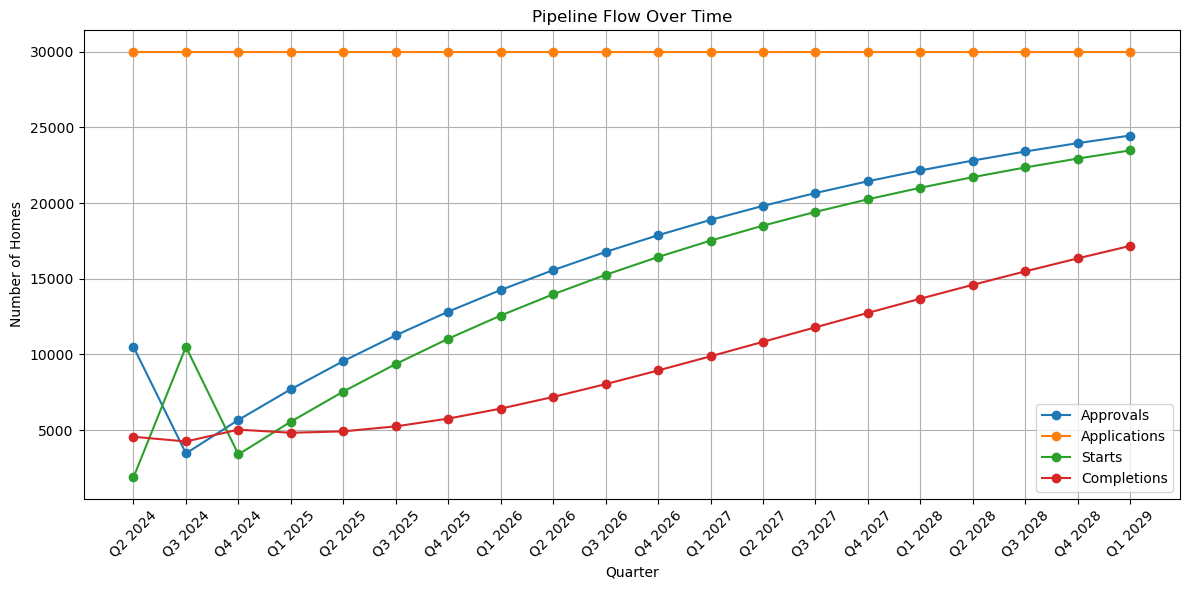

In [9]:
df = run_simulation(20, start_state = (11550, 10500, 34000, 0),
                         applications = 30000,
                         start_approved_flow = 10500,
                         start_starts_flow = 1879,
                         start_completions_flow=4561, 
                         planning_time = 12,
                         buildout_rate = .98,
                         approval_to_start_time = 1,
                         start_to_finish_time = 8)

plot_pipeline_flow(df)

# Experiments

Now let's try to fill this out with some real data!

To describe the start state in Q1 2024, we need:
- **Number of homes in the planning stage:** in 2024 q1 in London there were 14,600	applications received and 13,200 decided. This suggests that any given application had a 90% chance of being decided. So from the previous year we can expect a backlog of 1460 homes, from the year before that, a backlog of 146, then 15 then 1. Wich is a starting backlog of 1622. Ideally there is less volume staying in the application phase than there is flows in and out.
- **Number of homes with permission, not yet started:** if average time spent before construction is 6.8 quarters then starts * 6.8 = 12777
- **Number of homes under construction:** 50869

To contextualise what comes later we also need:
- **Number of planning applications:** 10146 (Molior - remarkable!) times .8 as that is the success rate usually (we only count those that will be successful, i.e. everything will eventually be granted) -> 8116
- **Number of planning permissions:** 1472 (Molior - quite striking!)
- **Number of starts:** 1879 (Molior)
- **Number of completions:** 4561 (Molior)

To calculate the rates of change:
- **Average time in planning:** 3.75 years = 15 quarters
- **Average time between planning and start:** 1.7 years = 6.8 quarters ("In the period since the NPPF, the planning to delivery period has extended up to 1.6 - 1.8 years")
- **Average time between start and finish:** 50869/4321  =  11.77 quarters

## Sources:
[1] https://lichfields.uk/media/w3wjmws0/start-to-finish-3_how-quickly-do-large-scale-housing-sites-deliver.pdf

[2] https://www.hbf.co.uk/documents/13634/HPL_REPORT_2024_Q1.pdf

[3] https://www.moliorlondon.com/database/reports/data/volumes/quarter/borough/


 

Here's the model run with the above estimates:

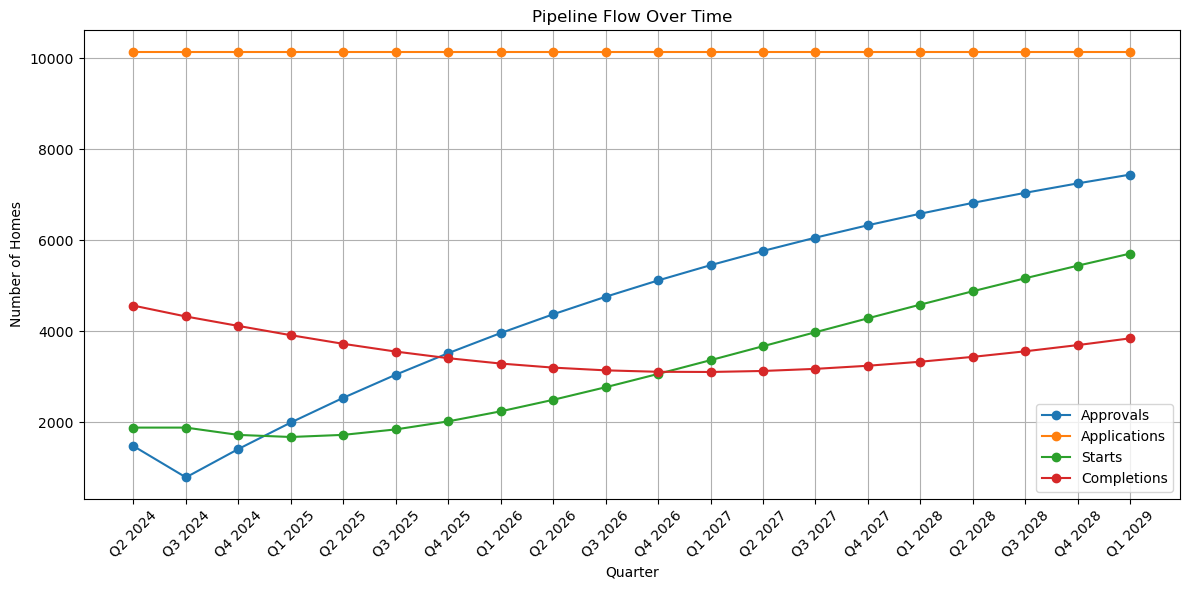

In [11]:
df = run_simulation(20, start_state = (1622, 12777, 50869, 0), #in planning, before start, in construction, completed
                         applications = 10146,
                         start_approved_flow = 1472,
                         start_starts_flow = 1879,
                         start_completions_flow=4561,
                         planning_time = 15,
                         buildout_rate = 1,
                         approval_to_start_time = 6.8,
                         start_to_finish_time = 11.77)


plot_pipeline_flow(df)

Model version with real values but with no stock values in the start state ("blank slate"):

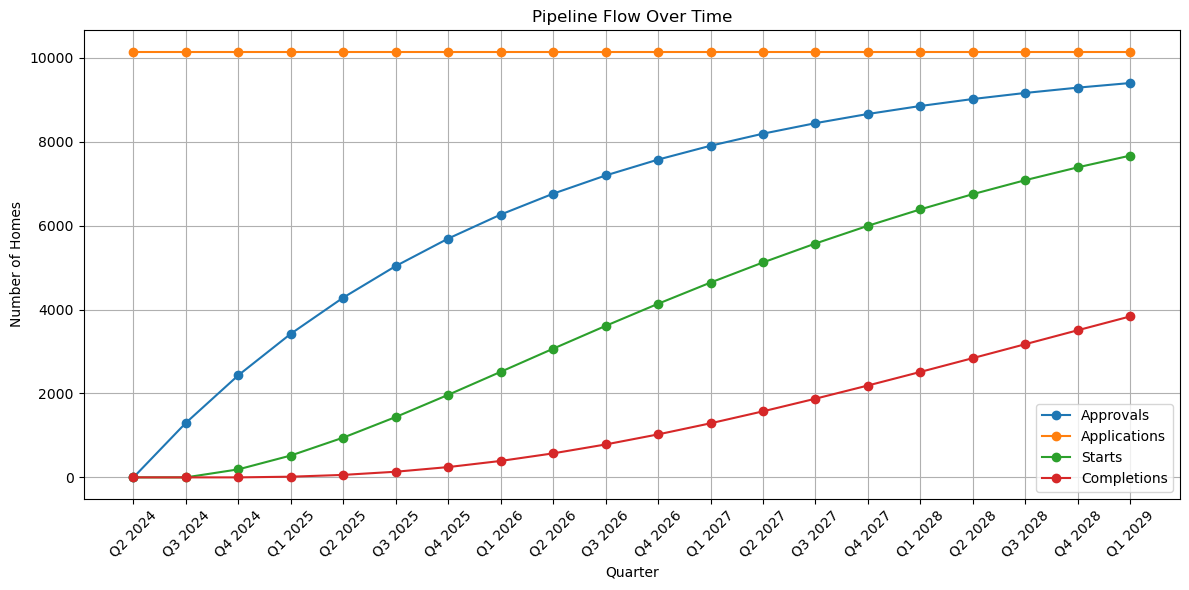

In [12]:
df = run_simulation(20, start_state = (0, 0, 0, 0), #in planning, before start, in construction, completed
                         applications = 10146,
                         start_approved_flow = 0,
                         start_starts_flow = 0,
                         start_completions_flow=0,
                         planning_time = 7.8,
                         buildout_rate = 1,
                         approval_to_start_time = 6.8,
                         start_to_finish_time = 11.77)


plot_pipeline_flow(df)

And here we introduce a version where we can interact with the plot. Another addition is that planning application numbers ramp up to a given number. This is here to play around with.

In [26]:
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact

def run_and_plot(top_applications, time_to_reach, planning_time, approval_to_start_time, start_to_finish_time, plot_values='flows'):
    df = run_simulation(20, start_state = (50000, 115000, 188000, 0), #in planning, before start, in construction, completed
                            applications = list(np.linspace(10146, top_applications, time_to_reach)) + [top_applications for i in range(20-time_to_reach)],
                            start_approved_flow = 1472,
                            start_starts_flow = 1879,
                            start_completions_flow=4561,
                            # planning_time=list(np.linspace(start_state[0] / 1472, planning_time, time_to_reach)) + [planning_time for i in range(20-time_to_reach)],
                            # planning_time=7.8,
                            planning_time=planning_time,
                            buildout_rate = 1,
                            # approval_to_start_time = list(np.linspace(start_state[1] / 1879, approval_to_start_time, time_to_reach)) + [approval_to_start_time for i in range(20-time_to_reach)],
                            # approval_to_start_time=6.8,
                            approval_to_start_time=approval_to_start_time,
                            # start_to_finish_time = list(np.linspace(start_state[2] / 4561, start_to_finish_time, time_to_reach)) + [start_to_finish_time for i in range(20-time_to_reach)])
                            # start_to_finish_time=5.2)
                            start_to_finish_time=start_to_finish_time)
    # plot either flow or volume values
    if plot_values == 'flows':
        plot_pipeline_flow(df)
    elif plot_values == 'volumes':
        plot_pipeline_volumes(df)

    return None

# Now run it with the interactivity
# interact(run_and_plot, 
#          top_applications=widgets.IntSlider(value=30000, min=0, max=100000, step=1000, description='Top applications'),
#          time_to_reach =widgets.IntSlider(value=8, min=0, max=20, step=1, description='Time to reach (quarters):'),
#          start_to_finish_time = widgets.FloatSlider(value=7.8, min=0, max=30, step=.1, description = 'Average time from start to finish (quarters)'),
#          planning_time = widgets.FloatSlider(value=7.8, min=0, max=20, step=.1, description = 'Average planning time (quarters)'),
#          approval_to_start_time = widgets.FloatSlider(value=6.8, min=0, max=20, step=.1, description = 'Average time from planning to start (quarters)'),
#          plot_values = widgets.RadioButtons(options=['flows', 'volumes'], value='flows'))

# These are derived from the momentary flow values. Probably a worst case scenario.

interact(run_and_plot, 
         top_applications=widgets.IntSlider(value=30000, min=0, max=100000, step=1000, description='Top applications'),
         time_to_reach =widgets.IntSlider(value=8, min=0, max=20, step=1, description='Time to reach (quarters):'),
         start_to_finish_time = widgets.FloatSlider(value=188000 / 4561, min=0, max=50, step=.1, description = 'Average time from start to finish (quarters)'),
         planning_time = widgets.FloatSlider(value=50000 / 1472, min=0, max=120, step=.1, description = 'Average planning time (quarters)'),
         approval_to_start_time = widgets.FloatSlider(value=115000 / 1879, min=0, max=65, step=.1, description = 'Average time from planning to start (quarters)'),
         plot_values = widgets.RadioButtons(options=['flows', 'volumes'], value='flows'))


interactive(children=(IntSlider(value=30000, description='Top applications', max=100000, step=1000), IntSlider…

<function __main__.run_and_plot(top_applications, time_to_reach, planning_time, approval_to_start_time, start_to_finish_time, plot_values='flows')>

In [ ]:
# Best case scenario
# First !todo! -- make the other flow control variables interactive as well...
# For now, let's say that the effects of the reforms are bunched together and are reached at the same timeline.

interact(run_and_plot, 
         top_applications=widgets.IntSlider(value=30000, min=0, max=100000, step=1000, description='Top applications'),
         time_to_reach =widgets.IntSlider(value=8, min=0, max=20, step=1, description='Time to reach (quarters):'),
         start_to_finish_time = widgets.FloatSlider(value=188000 / 4561, min=0, max=50, step=.1, description = 'Average time from start to finish (quarters)'),
         planning_time = widgets.FloatSlider(value=50000 / 1472, min=0, max=120, step=.1, description = 'Average planning time (quarters)'),
         approval_to_start_time = widgets.FloatSlider(value=115000 / 1879, min=0, max=65, step=.1, description = 'Average time from planning to start (quarters)'),
         plot_values = widgets.RadioButtons(options=['flows', 'volumes'], value='flows'))


# Thinking about scenarios

## The best-case scenario

In the best case scenario London reaches and maintains a very high level of housebuilding. The planning system performs better, and it takes less time than it did previously to get projects started and to deliver them. (This might be because there are more and smaller sites running in parallel, or new large sites that can deliver quickly.) The reviewed London Plan sets out ambitious housing targets. Local political resistance to new small-scale building eases as the public sentiment becomes more pro-housebuilding.